<a href="https://colab.research.google.com/github/Engineer-Gustavo-Softworks/TRATAMENTO-DE-DADOS-INMET-TAREFA-7-E-8/blob/main/POTENCIA_BRASILIA_2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import files
uploaded = files.upload()

Saving Planilha Brasilia 2010_excel.xlsx to Planilha Brasilia 2010_excel (1).xlsx


In [26]:
!pip install openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, weibull_min
from scipy.special import gamma
from scipy.optimize import fsolve
import math


df = pd.read_excel('Planilha Brasilia 2010_excel.xlsx', engine='openpyxl')

df_copia = df.copy (deep = True)
df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']] = df_copia [['DATA (YYYY-MM-DD)', 'HORA (UTC)', 'VENTO, VELOCIDADE HORARIA (m/s)']].replace(-9999,np.nan)

#De acordo com a distribuição do feature, decidi substituir os valores nulos por um método.
df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média

# Verificando a exitencia de valores duplicados:
df_copia.duplicated().sum()



<ipython-input-26-9a03aeb35dac>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].fillna(df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].mean(), inplace = True) #média


np.int64(0)

,DATA (YYYY-MM-DD),HORA (UTC),"VENTO, VELOCIDADE HORARIA (m/s)"
0,2010-01-01,00:00:00,2.44823
1,2010-01-01,01:00:00,2.44823
2,2010-01-01,02:00:00,2.44823
3,2010-01-01,03:00:00,2.44823
4,2010-01-01,04:00:00,2.44823


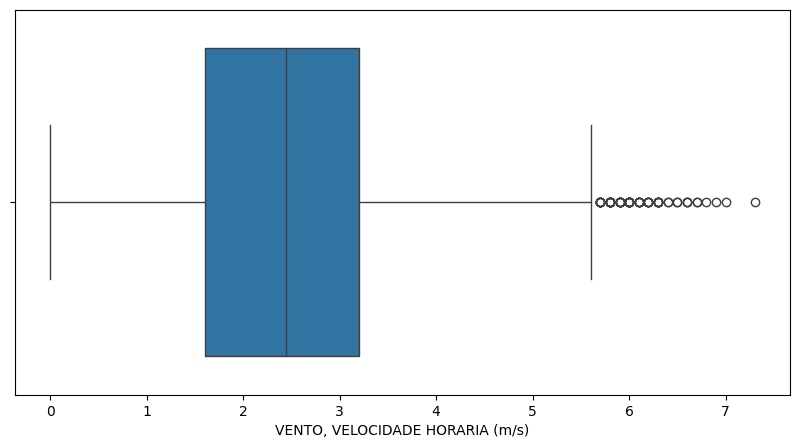

In [27]:
# Analisando a existencia de outleirs em 'VENTO, VELOCIDADE HORARIA (m/s)'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_copia['VENTO, VELOCIDADE HORARIA (m/s)'])

df_copia.describe()
df_copia.head()

> MÉTODO DA ENERGIA PADRÃO

Parâmetro beta (forma): 2.1681
Parâmetro eta (escala): 2.8206
[Momentos] beta: 1.9736, eta: 2.8015
[Máxima Verossimilhança] beta: 2.2422, eta: 2.8004


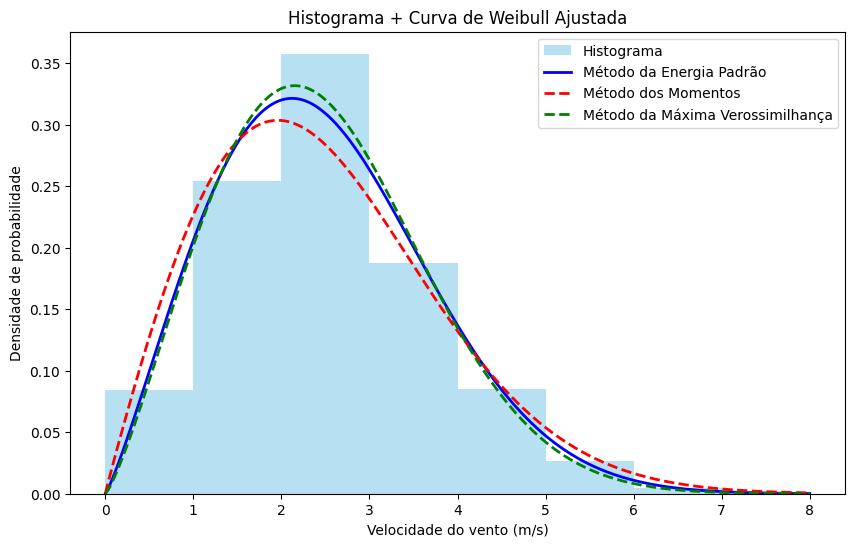

Limites dos bins do histograma: [0. 1. 2. 3. 4. 5. 6. 7. 8.]
Intervalo x para curva Weibull: 0.0 a 8.0


In [28]:
#Carregar os dados

coluna = 'VENTO, VELOCIDADE HORARIA (m/s)'
dados = df_copia[coluna].dropna().sort_values().values
dados = dados[dados > 0]
n = len(dados)

# -------Método da Enegia Padrão-------#

#Estimar a função de distribuição acumulada
i = np.arange(1, n + 1)
F = (i - 0.3) / (n + 0.4)

#Linearização e regressão
ln_t = np.log(dados)
ln_ln = np.log(-np.log(1 - F))

slope, intercept, *_ = linregress(ln_t, ln_ln)
beta = slope
eta = np.exp(-intercept / beta)

print(f"Parâmetro beta (forma): {beta:.4f}")
print(f"Parâmetro eta (escala): {eta:.4f}")

# -------Método dos Momentos-------#

# Momentos amostrais
media = np.mean(dados)
variancia = np.var(dados)

# Estimativa de beta (forma) por aproximação
def estimar_beta_mm(media, variancia):
    for b in np.linspace(0.5, 10, 10000):
        r = gamma(1 + 2/b) - (gamma(1 + 1/b))**2
        if np.isclose(r, variancia / media**2, atol=1e-4):
            return b
    return None

beta_mm = estimar_beta_mm(media, variancia)
eta_mm = media / gamma(1 + 1/beta_mm)

print(f"[Momentos] beta: {beta_mm:.4f}, eta: {eta_mm:.4f}")

# -------Método da Máxima Verossimilhança-------#

# Ajuste da distribuição Weibull aos dados
params = weibull_min.fit(dados, floc=0)
beta_mle, loc_mle, eta_mle = params
print(f"[Máxima Verossimilhança] beta: {beta_mle:.4f}, eta: {eta_mle:.4f}")

# Histograma + Curva de Weibull ajustada
plt.figure(figsize=(10, 6))

# Histograma normalizado
counts, bins, _ = plt.hist(dados, bins=[0,1,2,3,4,5,6,7,8], density=True, alpha=0.6, color='skyblue', label='Histograma')

#------------Curva de Weibull / MEP---------------#
# Eixo x para curva Weibull: mesma faixa do histograma
x = np.linspace(min(bins), max(bins), 300)

# Função densidade Weibull ajustada
weibull_pdf = (beta / eta) * (x / eta)**(beta - 1) * np.exp(-(x / eta)**beta)

# Plot da curva
plt.plot(x, weibull_pdf, 'b', lw=2, label='Método da Energia Padrão')

#------------Curva de Weibull / MM---------------#
pdf_mm = (beta_mm / eta_mm) * (x / eta_mm)**(beta_mm - 1) * np.exp(-(x / eta_mm)**beta_mm)
plt.plot(x, pdf_mm, 'r--', lw=2, label='Método dos Momentos')

#------------Curva de Weibull / MMV---------------#
pdf_mle = (beta_mle / eta_mle) * (x / eta_mle)**(beta_mle - 1) * np.exp(-(x / eta_mle)**beta_mle)
plt.plot(x, pdf_mle, 'g--', lw=2, label='Método da Máxima Verossimilhança')

# Ajustes visuais
plt.title('Histograma + Curva de Weibull Ajustada')
plt.xlabel('Velocidade do vento (m/s)')
plt.ylabel('Densidade de probabilidade')
plt.legend()
plt.grid(False)
plt.show()

print("Limites dos bins do histograma:", bins)
print("Intervalo x para curva Weibull:", x[0], "a", x[-1])


=== Tabela de Produção de Energia - Brasilia 2010 ===
VENTO, VELOCIDADE HORARIA (m/s)  Probabilidade (%)  Vel. média (m/s)  Potência (W)  Prob. × Potência (W)
                     (0.0, 1.0]              10.02              0.70          0.00                  0.00
                     (1.0, 2.0]              27.76              1.57          0.00                  0.00
                     (2.0, 3.0]              30.33              2.51          0.00                  0.00
                     (3.0, 4.0]              20.03              3.50          1.04                  0.21
                     (4.0, 5.0]               8.71              4.47         26.02                  2.27
                     (5.0, 6.0]               2.56              5.44        119.63                  3.06
                     (6.0, 7.0]               0.51              6.38        317.81                  1.62
                     (7.0, 8.0]               0.07              7.30        654.38                  0.46


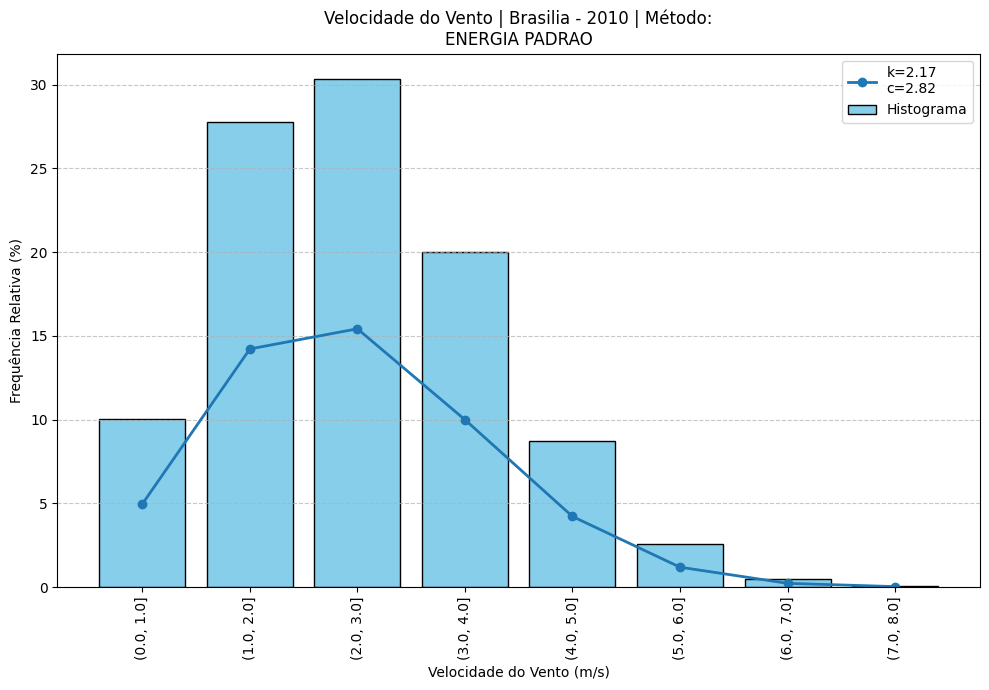

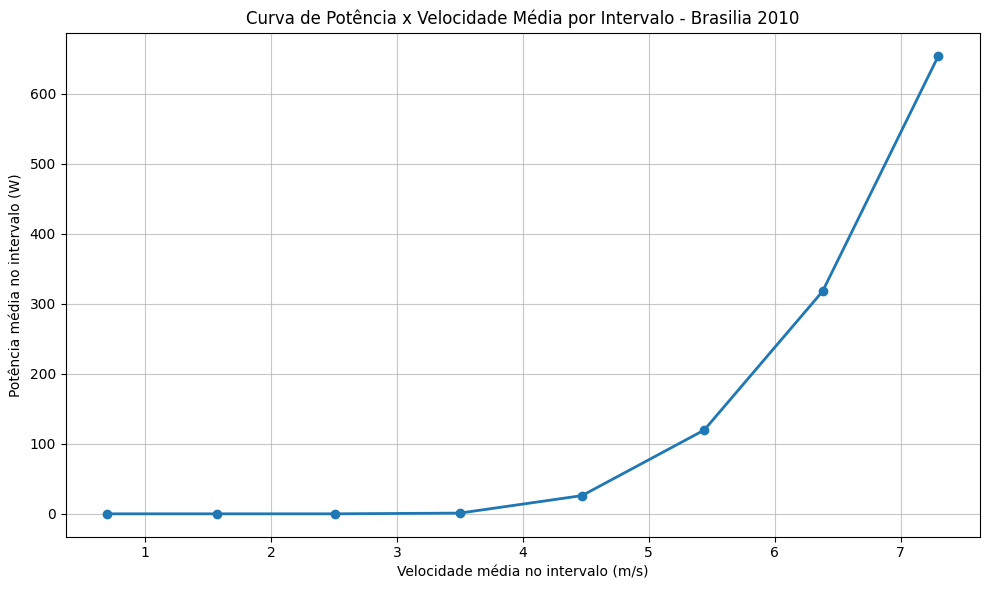

In [49]:
v = df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].values
v = v[v > 0]
n = len(v)
k = beta
c = eta

# === 3. FUNÇÃO DENSIDADE DE WEIBULL ===
def weibull(v, k, c, e=2.7182):
 return ((k / c) * (v / c) ** (k - 1) * e ** (-(v / c) ** k)) * 100 * 0.49875

 # === 4. FUNÇÃO DE POTÊNCIA FREEN-6 ===
def freen6_potencia(v):
 if v < 3 or v > 17:
  return 0
 elif v <= 12:
  return (6_000 / (12 - 3) ** 3) * (v - 3) ** 3
 else:
  return 6_000 # potência constante entre 12 e 17 m/s

  #=== 5. POTÊNCIA MÉDIA ===
def potencia_media_weibull(k, c, nb=100, p_func=freen6_potencia):
 u = np.linspace(0, 30, nb + 1)
 pot_media = 0
 for j in range(1, len(u)):
  uj_1 = u[j - 1]
  uj = u[j]
  delta_f = math.exp(-(uj_1 / c) ** k) - math.exp(-(uj / c) ** k)
  v_med = (uj + uj_1) / 2
  pot_media += delta_f * p_func(v_med)
 return pot_media

# === 6. TABELA DE PRODUÇÃO DE ENERGIA ===

dados_reais = df_copia['VENTO, VELOCIDADE HORARIA (m/s)'].dropna().values
dados_reais = dados_reais[dados_reais > 0]

def tabela_producao_energia(bins, k, c, dados_reais, p_func=freen6_potencia):
    faixas = []
    probabilidades = []
    velocidades_medias = []
    potencias = []
    energia_esperada = []

    # Crie os intervalos com base nos bins
    intervalos = pd.IntervalIndex.from_breaks(bins)

    for intervalo in intervalos:
        u1, u2 = intervalo.left, intervalo.right

        # Probabilidade pela função de Weibull
        p = (math.exp(-(u1 / c) ** k) - math.exp(-(u2 / c) ** k)) * 100

        # Filtra os dados reais que estão dentro do intervalo
        dados_intervalo = dados_reais[(dados_reais > u1) & (dados_reais <= u2)]

        # Calcula a média real (se houver dados)
        if len(dados_intervalo) > 0:
            v_med = np.mean(dados_intervalo)
        else:
            v_med = (u1 + u2) / 2  # fallback para evitar erro

        pot = p_func(v_med)
        energia = p * pot / 100

        faixas.append(str(intervalo))
        probabilidades.append(round(p, 2))
        velocidades_medias.append(round(v_med, 2))
        potencias.append(round(pot, 2))
        energia_esperada.append(round(energia, 2))

    tabela = pd.DataFrame({
        'VENTO, VELOCIDADE HORARIA (m/s)': faixas,
        'Probabilidade (%)': probabilidades,
        'Vel. média (m/s)': velocidades_medias,
        'Potência (W)': potencias,
        'Prob. × Potência (W)': energia_esperada
    })

    return tabela

# === 7. GRÁFICO ===
def plotar_grafico(tabela_faixas, k, c, cidade, ano, bins, metodo):
  # Need to get the midpoints of the bins for plotting the Weibull curve
  # É preciso obter os pontos médios dos bins para plotar a curva de Weibull
  v = (bins[:-1] + bins[1:]) / 2
  f_values = weibull(v, k, c)
  plt.figure(figsize=(10, 7))
  plt.bar(tabela_faixas['VENTO, VELOCIDADE HORARIA (m/s)'],
tabela_faixas['Probabilidade (%)'], # Use 'Probabilidade (%)' from the generated table # Use 'Probabilidade (%)' da tabela gerada
     color='skyblue', edgecolor='black', label='Histograma')
  # For plotting the curve against the bin labels, we can use the string labels directly
  # Para plotar a curva contra os rótulos dos bins, podemos usar os rótulos de string diretamente
  plt.plot(tabela_faixas['VENTO, VELOCIDADE HORARIA (m/s)'], f_values,marker='o', linestyle='-', linewidth=2, label=f'k={k:.2f}\nc={c:.2f}')
  plt.title(f'Velocidade do Vento | {cidade} - {ano} | Método:\n{metodo.upper()}')
  plt.xlabel('Velocidade do Vento (m/s)')
  plt.ylabel('Frequência Relativa (%)')
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.xticks(rotation=90)
  plt.tight_layout()


# Assuming 'cidade', 'ano', and 'metodo' are defined elsewhere or need to be defined
# Supondo que 'cidade', 'ano' e 'metodo' estejam definidos em outro lugar ou precisem ser definidos
cidade = 'Brasilia' # Example value # Valor de exemplo
ano = 2010 # Example value # Valor de exemplo
metodo = 'Energia Padrao' # Example value # Valor de exemplo

# Assuming bins is still the output from the plt.hist function in the previous cell
# Supondo que bins ainda seja a saída da função plt.hist na célula anterior

# Gera e exibe a tabela de produção
tabela_energia = tabela_producao_energia(bins, k, c, dados_reais)
print("\n=== Tabela de Produção de Energia - Brasilia 2010 ===")
print(tabela_energia.to_string(index=False))

# Prepare data for the plot, using the generated tabela_energia
# Prepara dados para o gráfico, usando a tabela_energia gerada
# The plotar_grafico function expects 'Frequência Relativa (%)' and 'Faixa de Velocidade (m/s)'
# The generated table has 'Probabilidade (%)' and 'VENTO, VELOCIDADE HORARIA (m/s)'
# Adjusting the call or the plotar_grafico function is needed.
# For now, let's pass the tabela_energia and adjust plotar_grafico to use its columns.
# A função plotar_grafico espera 'Frequência Relativa (%)' e 'Faixa de Velocidade (m/s)'
# A tabela gerada tem 'Probabilidade (%)' e 'VENTO, VELOCIDADE HORARIA (m/s)'
# É necessário ajustar a chamada ou a função plotar_grafico.
# Por enquanto, vamos passar a tabela_energia e ajustar plotar_grafico para usar suas colunas.
plotar_grafico(tabela_energia, k, c, cidade, ano, bins, metodo)


# 1. Eixo X: velocidades médias dentro de cada intervalo
x = tabela_energia['Vel. média (m/s)']

# 2. Eixo Y: potência média em cada intervalo
y = tabela_energia['Potência (W)']

# 3. Plot da curva
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', linewidth=2)

# 4. Estética
plt.title('Curva de Potência x Velocidade Média por Intervalo - Brasilia 2010')
plt.xlabel('Velocidade média no intervalo (m/s)')
plt.ylabel('Potência média no intervalo (W)')
plt.grid(True, linestyle='-', alpha=0.7)
plt.tight_layout()
plt.show()